<a href="https://colab.research.google.com/github/asiabak/Licencjat-modele/blob/main/kNN_z_wykresami_i_macierzami_pomy%C5%82ek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalowanie potrzebnych paczek

In [1]:
!pip install gensim
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [1]:
from gensim.models import KeyedVectors

# Pobranie modelu
model_url = "https://huggingface.co/clarin-pl/word2vec-kgr10/resolve/main/skipgram.v300.m8.ns.mwe.w2v.gensim"
model_path = "word2vec-kgr10.gensim"

# Pobranie pliku
import urllib.request
urllib.request.urlretrieve(model_url, model_path)

# Download the vectors file separately
vectors_url = "https://huggingface.co/clarin-pl/word2vec-kgr10/resolve/main/skipgram.v300.m8.ns.mwe.w2v.gensim.vectors.npy" # URL of the vectors file
vectors_path = "word2vec-kgr10.gensim.vectors.npy" # Local path for the vectors file
urllib.request.urlretrieve(vectors_url, vectors_path)

# Załadowanie modelu
model = KeyedVectors.load(model_path)

Tworzenie dwóch datasetów: reviews - bez idiomów oraz reviews_with_idioms

In [15]:
import pandas as pd

reviews = pd.read_csv("polemo2.0_good_labels.csv")
reviews_with_idioms = pd.read_csv('polemo2.0_i_idiomy.csv')
print(reviews.head())

                                              review  sentiment
0  Na samym wejściu hotel śmierdzi . W pokojach j...         -1
1  Ze swoimi dziećmi ( 10 lat i 2 latka ) chodzę ...          1
2  Chciał em zestaw do podstawowych prac coś przy...         -1
3  Drogie Mamy . Mam o tym laktatorze takie same ...         -1
4  własciwie nic się nie dowidział em , podczas b...         -1


Text preprocessing (lowercase, usunięcie interpunkcji, tokenizacja) i wektoryzacja tekstu

In [16]:
import re
import numpy as np
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

# Wczytanie listy polskich stop words z pliku
# with open('polish.stopwords.txt', 'r', encoding='utf-8') as file:
#     polish_stopwords = set(file.read().splitlines())

def preprocess_text(text):
    # Konwersja na małe litery
    text = text.lower()

    # Usunięcie znaków interpunkcyjnych
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenizacja
    words = text.split()

    # Usunięcie stop words
    # words = [word for word in words if word not in polish_stopwords]

    # Połączenie słów z powrotem w tekst
    return ' '.join(words)

# Zastosowanie przetwarzania tekstu dla kolumny 'review'
reviews['review_processed'] = reviews['review'].apply(preprocess_text)
reviews_with_idioms['review_processed'] = reviews_with_idioms['review'].apply(preprocess_text)

# Wyświetlenie przykładowych przetworzonych recenzji
# print("Przykładowe przetworzone recenzje:")
# print(reviews[['review', 'review_processed']].head(2))

# Aktualizacja funkcji wektoryzacji, aby używała przetworzonych recenzji
def vectorize_review(text, model):
    words = word_tokenize(text.lower())
    words = [word for word in words if word in model.key_to_index]

    if words:
        return np.mean(model[words], axis=0)  # Średnia wektorów słów
    else:
        return np.zeros(model.vector_size)  # Zerowy wektor, jeśli brak znanych słów

# Aktualizacja wektorów dla przetworzonych recenzji
reviews['vector'] = reviews['review_processed'].apply(lambda x: vectorize_review(x, model))
reviews_with_idioms['vector'] = reviews_with_idioms['review_processed'].apply(lambda x: vectorize_review(x, model))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Przygotowanie danych i trenowanie modelu

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Przygotowanie danych
X = np.vstack(reviews['vector'].values)
y = reviews['sentiment'].values
X2 = np.vstack(reviews_with_idioms['vector'].values)
y2 = reviews_with_idioms['sentiment'].values

# Podział na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=None, random_state=12)

# Trening modelu kNN na samych recenzjach
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predykcja i ocena
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))


# Trening modelu kNN na recenzjach i idiomach
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X2_train, y2_train)

# Predykcja i ocena
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.49      0.38      0.43       557
           0       0.19      0.07      0.11       231
           1       0.64      0.81      0.71      1008

    accuracy                           0.58      1796
   macro avg       0.44      0.42      0.42      1796
weighted avg       0.54      0.58      0.55      1796

              precision    recall  f1-score   support

          -1       0.60      0.56      0.58       557
           0       0.35      0.17      0.23       231
           1       0.71      0.82      0.76      1008

    accuracy                           0.66      1796
   macro avg       0.55      0.52      0.52      1796
weighted avg       0.63      0.66      0.64      1796



Kod wzbogacony o wykresy:

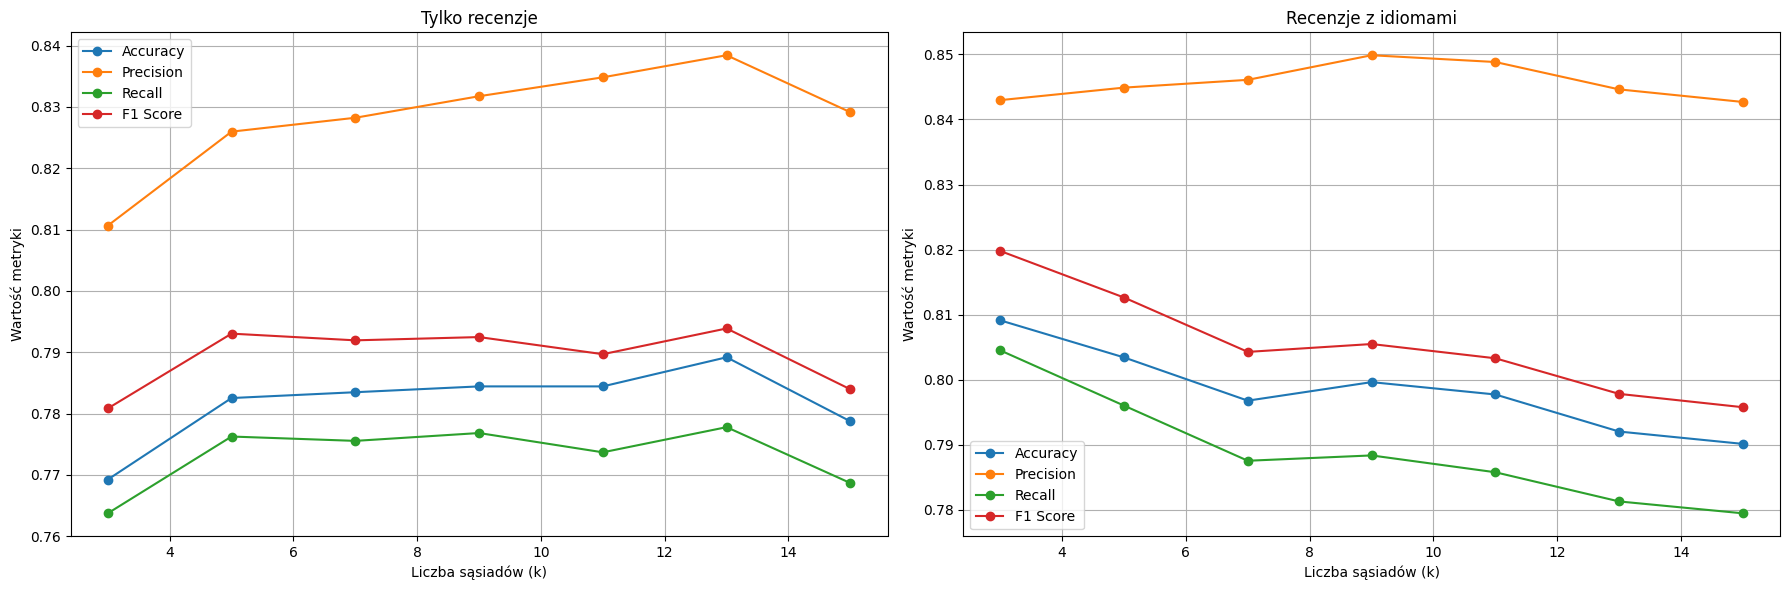

Najlepsze k dla recenzji bez idiomów: 13 (F1 score: 0.794)
Najlepsze k dla recenzji z idiomami: 3 (F1 score: 0.820)


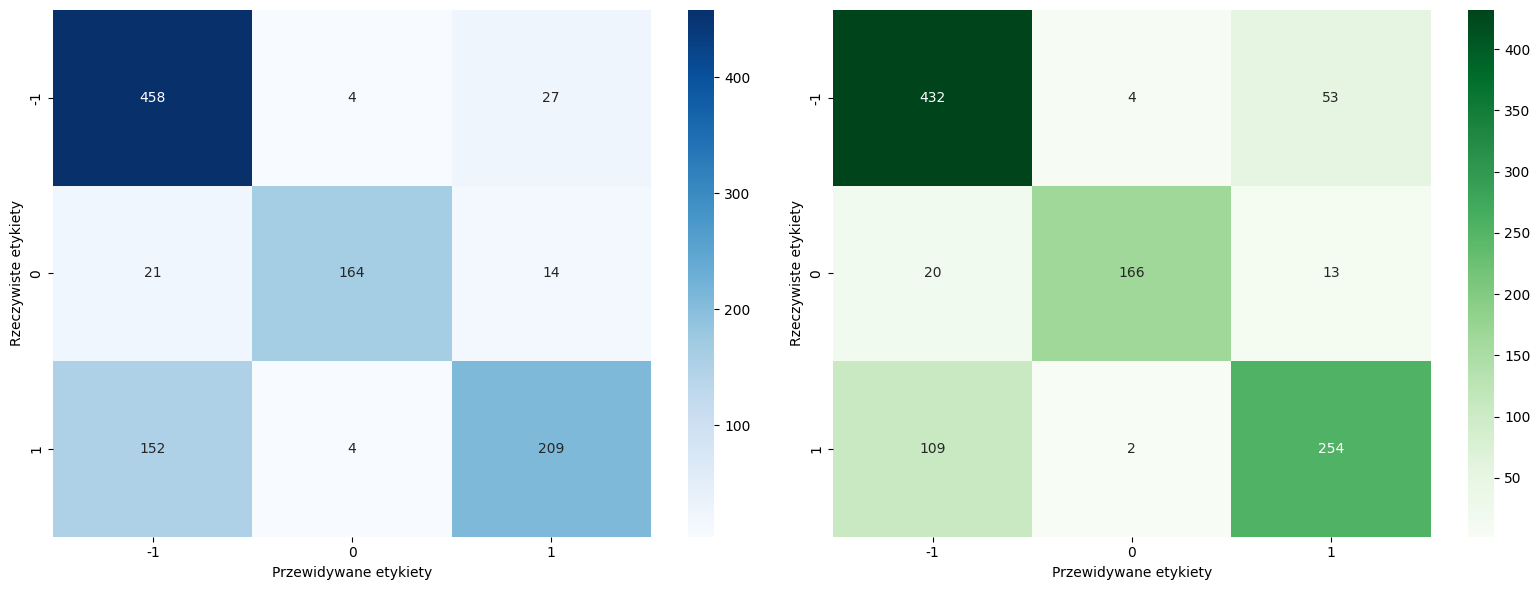


RAPORT KLASYFIKACJI - TYLKO RECENZJE
              precision    recall  f1-score   support

          -1       0.73      0.94      0.82       489
           0       0.95      0.82      0.88       199
           1       0.84      0.57      0.68       365

    accuracy                           0.79      1053
   macro avg       0.84      0.78      0.79      1053
weighted avg       0.81      0.79      0.78      1053


RAPORT KLASYFIKACJI - RECENZJE Z IDIOMAMI
              precision    recall  f1-score   support

          -1       0.77      0.88      0.82       489
           0       0.97      0.83      0.89       199
           1       0.79      0.70      0.74       365

    accuracy                           0.81      1053
   macro avg       0.84      0.80      0.82      1053
weighted avg       0.82      0.81      0.81      1053


PORÓWNANIE WYNIKÓW
Tylko recenzje - Najlepsze k: 13
  Accuracy: 0.789
  Precision: 0.838
  Recall: 0.778
  F1 Score: 0.794

Recenzje z idiomami - Najlepsze 

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Przygotowanie danych
X = np.vstack(reviews['vector'].values)
y = reviews['sentiment'].values
X2 = np.vstack(reviews_with_idioms['vector'].values)
y2 = reviews_with_idioms['sentiment'].values

# Podział na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=None, random_state=12)

# Lista liczby sąsiadów
number_neighbors = [3, 5, 7, 9, 11, 13, 15]

# Funkcja do zbierania metryk
def evaluate_knn(X_train, X_test, y_train, y_test):
    acc, prec, rec, f1 = [], [], [], []
    for k in number_neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        acc.append(accuracy_score(y_test, y_pred))
        prec.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        rec.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
        f1.append(f1_score(y_test, y_pred, average='macro', zero_division=0))
    return acc, prec, rec, f1

# Obliczenie metryk dla obu zestawów
acc1, prec1, rec1, f1_1 = evaluate_knn(X_train, X_test, y_train, y_test)
acc2, prec2, rec2, f1_2 = evaluate_knn(X2_train, X_test, y2_train, y_test)

# Rysowanie dwóch wykresów
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Wykres dla samych recenzji
ax1.plot(number_neighbors, acc1, label='Accuracy', marker='o')
ax1.plot(number_neighbors, prec1, label='Precision', marker='o')
ax1.plot(number_neighbors, rec1, label='Recall', marker='o')
ax1.plot(number_neighbors, f1_1, label='F1 Score', marker='o')
ax1.set_title('Tylko recenzje')
ax1.set_xlabel('Liczba sąsiadów (k)')
ax1.set_ylabel('Wartość metryki')
ax1.legend()
ax1.grid(True)

# Wykres dla recenzji z idiomami
ax2.plot(number_neighbors, acc2, label='Accuracy', marker='o')
ax2.plot(number_neighbors, prec2, label='Precision', marker='o')
ax2.plot(number_neighbors, rec2, label='Recall', marker='o')
ax2.plot(number_neighbors, f1_2, label='F1 Score', marker='o')
ax2.set_title('Recenzje z idiomami')
ax2.set_xlabel('Liczba sąsiadów (k)')
ax2.set_ylabel('Wartość metryki')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# === DODANY KOD - MACIERZE KONFUZJI ===

# Wybieramy najlepsze k na podstawie F1 score
best_k_idx_1 = np.argmax(f1_1)
best_k_1 = number_neighbors[best_k_idx_1]

best_k_idx_2 = np.argmax(f1_2)
best_k_2 = number_neighbors[best_k_idx_2]

print(f"Najlepsze k dla recenzji bez idiomów: {best_k_1} (F1 score: {f1_1[best_k_idx_1]:.3f})")
print(f"Najlepsze k dla recenzji z idiomami: {best_k_2} (F1 score: {f1_2[best_k_idx_2]:.3f})")

# Trenowanie modeli z najlepszymi parametrami k
knn_1 = KNeighborsClassifier(n_neighbors=best_k_1)
knn_1.fit(X_train, y_train)
y_pred_1 = knn_1.predict(X_test)

knn_2 = KNeighborsClassifier(n_neighbors=best_k_2)
knn_2.fit(X2_train, y2_train)
y_pred_2 = knn_2.predict(X_test)

# Tworzenie macierzy konfuzji
cm_1 = confusion_matrix(y_test, y_pred_1)
cm_2 = confusion_matrix(y_test, y_pred_2)

# Pobieranie unikalnych etykiet sentiment
labels_1 = sorted(np.unique(y))
labels_2 = sorted(np.unique(y2))

# Konwersja etykiet na stringi dla classification_report
labels_1_str = [str(label) for label in labels_1]
labels_2_str = [str(label) for label in labels_2]

# Rysowanie macierzy konfuzji
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Macierz konfuzji dla recenzji bez idiomów
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=labels_1, yticklabels=labels_1)
ax1.set_xlabel('Przewidywane etykiety')
ax1.set_ylabel('Rzeczywiste etykiety')

# Macierz konfuzji dla recenzji z idiomami
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=labels_2, yticklabels=labels_2)
ax2.set_xlabel('Przewidywane etykiety')
ax2.set_ylabel('Rzeczywiste etykiety')

plt.tight_layout()
plt.show()

# Wyświetlenie szczegółowych raportów klasyfikacji
print("\n" + "="*50)
print("RAPORT KLASYFIKACJI - TYLKO RECENZJE")
print("="*50)
print(classification_report(y_test, y_pred_1, target_names=labels_1_str))

print("\n" + "="*50)
print("RAPORT KLASYFIKACJI - RECENZJE Z IDIOMAMI")
print("="*50)
print(classification_report(y_test, y_pred_2, target_names=labels_2_str))

# Porównanie wyników
print("\n" + "="*50)
print("PORÓWNANIE WYNIKÓW")
print("="*50)
print(f"Tylko recenzje - Najlepsze k: {best_k_1}")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_1):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_1, average='macro', zero_division=0):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_1, average='macro', zero_division=0):.3f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_1, average='macro', zero_division=0):.3f}")

print(f"\nRecenzje z idiomami - Najlepsze k: {best_k_2}")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_2):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_2, average='macro', zero_division=0):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_2, average='macro', zero_division=0):.3f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_2, average='macro', zero_division=0):.3f}")

# Obliczenie i wyświetlenie różnic w wydajności
acc_diff = accuracy_score(y_test, y_pred_2) - accuracy_score(y_test, y_pred_1)
prec_diff = precision_score(y_test, y_pred_2, average='macro', zero_division=0) - precision_score(y_test, y_pred_1, average='macro', zero_division=0)
rec_diff = recall_score(y_test, y_pred_2, average='macro', zero_division=0) - recall_score(y_test, y_pred_1, average='macro', zero_division=0)
f1_diff = f1_score(y_test, y_pred_2, average='macro', zero_division=0) - f1_score(y_test, y_pred_1, average='macro', zero_division=0)

print(f"\nRÓŻNICE (z idiomami - bez idiomów):")
print(f"  Accuracy: {acc_diff:+.3f}")
print(f"  Precision: {prec_diff:+.3f}")
print(f"  Recall: {rec_diff:+.3f}")
print(f"  F1 Score: {f1_diff:+.3f}")